## This notebook is tested and supposted to be used in kaggle notebbok.

https://www.kaggle.com/code/alexandrmaximenko/audiollm-hw

In [1]:
import torch
import librosa
from transformers import AutoModel, AutoProcessor, WhisperFeatureExtractor, WhisperModel, AutoTokenizer, AutoModelForCausalLM
from transformers.generation import GenerationConfig
import transformers
import pandas as pd
import json
from tqdm import tqdm
import IPython
import gc
import os
from dataclasses import dataclass
import torch.nn as nn

# There might me Errors like 
# "AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'"
# It's okay and won't effect notebook executio

2025-12-01 18:54:44.799867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764615284.987944      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764615285.037783      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# downloading helping visualizations
! gdown https://drive.google.com/uc?id=1k8LeWGhsn1fTXbrn9JV08lKUTOJeoEwz

Downloading...
From: https://drive.google.com/uc?id=1k8LeWGhsn1fTXbrn9JV08lKUTOJeoEwz
To: /kaggle/working/embeddings_visualization.png
100%|████████████████████████████████████████| 299k/299k [00:00<00:00, 93.8MB/s]


# Homework: Audio Language Model Training and Evaluation (10 points)

In this homework, you will implement AudioLLM training pipeline and check it correctness with overfitting experiment.

Then, you'll take pretrained checkpoint and config for AudioLLM and write code for it's evaluation.


**Good luck! 🚀**

### Data Generation Pipeline (2 points)
Implement a QA-data generation pipeline from ASR (Automatic Speech Recognition) dataset
- Start with ASR dataset containing `(audio, transcript)` pairs
- Use the transcript to prompt an instruction-tuned LLM to generate question based on the transcript
- Use the transcript & question to prompt an instruction-tuned LLM to generate answer for this question based on transcript
- Create `(audio, question, anwer)` pairs for training

**Expected output**: A data generation script that transforms ASR data into QA-dataset + some generated samples

Expected sample format:
```
{
  "audio_path": "some_audio_path.flac",
  
  "transcript": "So today we're going to talk about how to prepare for a marathon if you only have twelve weeks...",
  
  "question": "How long does the speaker say you have to prepare for the marathon?",
  
  "answer": "Twelve weeks."
}
```

#### Grading Criteria:
* **2 points:** Completed *<TODO>* code in the `QADataGeneratorHF` + meaningfull examples of questions/answers in the last cell, completed `check_response` if needed
* **1 point:**: Completed *<TODO>* code in the `QADataGeneratorHF` + many bugs in examples like incorrect format / model refusals
* **0 points:** lack of meaningful data examples / unexecutable code

---

In [3]:
# Download librispeech dev-clean data
! wget https://openslr.elda.org/resources/12/dev-clean.tar.gz \
  && tar -xf dev-clean.tar.gz

--2025-12-01 18:55:58--  https://openslr.elda.org/resources/12/dev-clean.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application/x-gzip]
Saving to: ‘dev-clean.tar.gz’

dev-clean.tar.gz    100%[===================>] 322.27M  20.1MB/s    in 15s     

2025-12-01 18:56:14 (20.9 MB/s) - ‘dev-clean.tar.gz’ saved [337926286/337926286]



In [4]:
from pathlib import Path
import json

DEV_CLEAN_ROOT = Path("/kaggle/working/LibriSpeech/dev-clean")


# Parse all transcript files into a dict: utt_id -> transcription
def load_transcripts(root: Path) -> dict:
    transcripts = {}
    for trans_file in root.rglob("*.trans.txt"):
        with open(trans_file, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                utt_id = parts[0]              # e.g. "84-121123-0000"
                text = " ".join(parts[1:])
                transcripts[utt_id] = text
    return transcripts

transcripts = load_transcripts(DEV_CLEAN_ROOT)
print("Loaded transcripts:", len(transcripts))

# Create JSONL with one entry per audio file
output_json = Path("/kaggle/working/dev-clean.json")
librispeech_data = []
for flac_path in sorted(DEV_CLEAN_ROOT.rglob("*.flac")):
    utt_id = flac_path.stem  # filename without .flac
    text = transcripts.get(utt_id)
    record = {
        "audio_path": str(flac_path),    # full path inside Kaggle FS
        "transcription": text,
    }
    librispeech_data.append(record)
    
with output_json.open("w", encoding="utf-8") as f:
    json.dump(librispeech_data, f)
        

print("Wrote JSONL to:", output_json)

Loaded transcripts: 2703
Wrote JSONL to: /kaggle/working/dev-clean.json


In [5]:
# Example of data sample
index = torch.randint(len(librispeech_data), (1,))
print('Data sample transcription:\n', librispeech_data[index]['transcription'])
IPython.display.Audio(librispeech_data[index]['audio_path'])

Data sample transcription:
 YES INDEED AND I BELIEVE IT IS RIGHT THAT I SHOULD KEEP MY FIRST PROMISE IS IT NOT


In [9]:
BASE_SYSTEM_MESSAGE = (
    "You are a helpful assistant. "
    "Keep your responses concise — maximum 50 words or 2–3 sentences."
)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class QADataGeneratorHF:
    def __init__(self, model_path: str = "Qwen/Qwen2.5-1.5B-Instruct"):
        print(f"Loading tokenizer: {model_path}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)

        print(f"Loading transformers model: {model_path}")
        self.device = DEVICE
        self.model = AutoModelForCausalLM.from_pretrained(
                        model_path,
                        torch_dtype="auto",
                        device_map="auto"
                    )
        self.model.eval()

        self.generation_kwargs = dict(
            temperature=0.8,
            top_p=0.9,
            max_new_tokens=256,
            do_sample=True,
        )

        self.system_message = BASE_SYSTEM_MESSAGE
        self.user_prompt = """
Based on the [TRANSCRIPTION] below make a short simple question about some information in this [TRANSCRIPTION] and answer it.
Return a JSON object like:
{{
    "question": "...",
    "answer": "..."
}}
TRANSCRIPTION: {transcription}
"""

    
    @torch.inference_mode()
    def generate_single(self, transcription: str) -> str: # here we have to return a dict????
        messages = [
            {"role": "system", "content": self.system_message},
            {"role": "user", "content": self.user_prompt.format(transcription=transcription)}
        ]
        text = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = self.tokenizer([text], return_tensors="pt").to(self.device)

        generated_ids = self.model.generate(
            **model_inputs,
            max_new_tokens=512
        )
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        content = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        if "```json" in content:
            content = content.split("```json")[1].split("```")[0]
        elif "```" in content:
            content = content.split("```")[1].split("```")[0]

        try:
            resp_dict = json.loads(content.strip())
        except JSONDecodeError:
            print(f"Json decoder error on the item: {content}")
            return None
        except Exception as ex:
            print(f"Unexpected error: {ex}")
            return None
        return resp_dict

    def generate_batch(self, transcriptions: list[str]) -> list[str]:
        """Generate responses for a list of transcriptions with progress bar."""
        responses = []
        for transcription in tqdm(transcriptions, desc="Generating responses"):
            response = self.generate_single(transcription)
            responses.append(response)
        
        return responses

In [10]:
generator = QADataGeneratorHF("Qwen/Qwen2.5-1.5B-Instruct")

Loading tokenizer: Qwen/Qwen2.5-1.5B-Instruct
Loading transformers model: Qwen/Qwen2.5-1.5B-Instruct


In [11]:
NUM_SAMPLES = 100
librispeech_data_sample = librispeech_data[:NUM_SAMPLES]
transcriptions = [sample['transcription'] for sample in librispeech_data_sample]

generated_responses = generator.generate_batch(transcriptions)

Generating responses: 100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


In [12]:
# Check your instruct data samples
index = torch.randint(NUM_SAMPLES, (1,))
print('Transcription example: ', librispeech_data_sample[index]['transcription'])
print('='*100)
print('Question example: ', generated_responses[index]['question'])
print('='*100)
print('Answer example: ', generated_responses[index]['answer'])

Transcription example:  IT IS OBVIOUSLY UNNECESSARY FOR US TO POINT OUT HOW LUMINOUS THESE CRITICISMS ARE HOW DELICATE IN EXPRESSION
Question example:  What is being criticized?
Answer example:  Luminous criticisms


In [13]:
## Add simple filtering

def check_response(response: str) -> bool:
    return True #<TODO>

generated_samples = []
rejected_samples = []

for data_sample, response in zip(librispeech_data_sample[:NUM_SAMPLES], generated_responses):
    if check_response(response):
        data_sample.update(response)
        generated_samples.append(data_sample)
    else:
        data_sample.update(response)
        rejected_samples.append(data_sample)

print('Number of samples before filtering: ', NUM_SAMPLES)
print('Number of samples after filtering: ', len(generated_samples))
with open('instruct_data.json', 'w') as file:
    json.dump(generated_samples, file)

Number of samples before filtering:  100
Number of samples after filtering:  100


In [14]:
# Check rejected samples
index = torch.randint(len(rejected_samples), (1,))
print('Transcription example: ', rejected_samples[index]['transcription'])
print('Response example: ', rejected_samples[index]['response'])

RuntimeError: random_ expects 'from' to be less than 'to', but got from=0 >= to=0

In [15]:
# Check good samples
index = torch.randint(len(generated_samples), (1,))
print('Transcription example: ', generated_samples[index]['transcription'])
print('='*100)
print('Question example: ', generated_samples[index]['question'])
print('='*100)
print('Answer example: ', generated_samples[index]['answer'])

Transcription example:  THE FACT IS SHE'S FEELING RATHER SEEDY POOR CHILD
Question example:  How is she feeling?
Answer example:  Rather seedy poor child



#### Grading Criteria:
* **2 points:** Completed *<TODO>* code in the `QADataGeneratorHF` + meaningfull examples of questions/answers in the last cell, completed `check_response` if needed
* **1 point:**: Completed *<TODO>* code in the `QADataGeneratorHF` + many bugs in examples like incorrect format / model refusals
* **0 points:** lack of meaningful data examples / unexecutable code

---

### 2. AudioLLM Model & Dataset & Overfitting (4 points)

In this section you'll need to: 
* Implement AudioLLM model with architecture, similar to UltraVox.

* Implement dataset class for this model based on QA-samples you've generated earlier

* Run overfitting experiment with your model and your dataset


#### Grading Criteria:
* **+2 points:** Completed *<TODO>* code in the `AudioAdapter` and in the `AudioLLM`, `AudioEmbeddingInsertionTests` passed
* **+1 point:** Completed *<TODO>* code in the `AudioInstructDataset` + demonstration of dataset samples
* **+1 point:** Reaching `loss < 0.2` on your overfit experiment

---

Let start with model.

**Model components**:
  - Audio encoder - Whisper
  - Audio Adapter - Linear with subsampling
  - Language model

Your first task - to fill **`#<TODO>`** parts in AudioAdapter and AudioLLM classes.

##### Grading Criteria:
* **2 points:** Completed *<TODO>* code in the `AudioAdapter` and in the `AudioLLM`, `AudioEmbeddingInsertionTests` passed
* **1 point:** Completed *<TODO>* code in the `AudioAdapter`, `AudioEmbeddingInsertionTests` failed

In [16]:
@dataclass
class ModelConfig:
    """Configuration for the Audio LLM model."""
    
    whisper_model: str = "openai/whisper-small"
    llm_model: str = "Qwen/Qwen3-0.6B"
    
    # Audio adapter
    adapter_hidden_dim: int = 1024 # corresponding to llm input dimension
    adapter_num_layers: int = 2
    adapter_dropout: float = 0.1
    subsample_factor: int = 4

    # Training strategy
    freeze_whisper: bool = True  # Freeze Whisper encoder
    freeze_llm: bool = True  # Set to True for adapter-only training (no LoRA needed)


In [17]:
class AudioAdapter(nn.Module):
    def __init__(
        self,
        whisper_dim: int,
        llm_dim: int,
        hidden_dim: int = 2048,
        num_layers: int = 2,
        dropout: float = 0.1,
        subsample_factor: int = 1
    ):
        """
        Simple MLP Adapter with configurable subsample_factor
        """
        super().__init__()
        self.subsample_factor = subsample_factor

        # Set input_dim according to subsample_factor and whisper_dim
        # несколько временных шагов объединяются в один, конкатенируя их признаки
        input_dim = whisper_dim * subsample_factor
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim),
                nn.GELU(),
                nn.Dropout(dropout)
            )
            for _ in range(num_layers - 1)
        ])

        self.output_proj = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, llm_dim)
        )

    def forward(self, whisper_features: torch.Tensor) -> torch.Tensor:
        if self.subsample_factor > 1:
            batch_size, seq_len, dim = whisper_features.shape
            remainder = seq_len % self.subsample_factor
            if remainder != 0:
                whisper_features = whisper_features[:, :-remainder, :]
                seq_len = whisper_features.shape[1]
            new_seq_len = seq_len // self.subsample_factor
            x = whisper_features.reshape(batch_size, new_seq_len, dim * self.subsample_factor)
        else:
            x = whisper_features

        # Applying input projection
        x = self.input_proj(x)

        for layer in self.layers:
            x = x + layer(x)

        # Applying output projection
        x = self.output_proj(x)
        return x

In [18]:
AUDIO_TOKEN = "<|audio_token|>"

class AudioLLM(nn.Module):
    """
    Audio Language Model combining Whisper encoder with a text LLM.
    
    Architecture:
    1. Whisper encoder processes audio
    2. Audio adapter projects features to LLM space
    3. LLM generates text conditioned on audio features
    """
    
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.model_config = config
        
        # Load Whisper encoder
        print(f"Loading Whisper model: {config.whisper_model}")
        whisper = WhisperModel.from_pretrained(config.whisper_model)
        self.whisper_encoder = whisper.encoder
        whisper_dim = self.whisper_encoder.config.d_model
        
        if config.freeze_whisper:
            for param in self.whisper_encoder.parameters():
                param.requires_grad = False
            print("Whisper encoder frozen")
        
        # Load LLM
        print(f"Loading LLM: {config.llm_model}")
        self.llm = AutoModelForCausalLM.from_pretrained(
            config.llm_model,
            torch_dtype=torch.bfloat16
        )

        # Adding special audio token
        self.tokenizer = AutoTokenizer.from_pretrained(config.llm_model)
        self.tokenizer.add_special_tokens({"additional_special_tokens": [AUDIO_TOKEN]})
        self.audio_token_id = self.tokenizer(AUDIO_TOKEN, add_special_tokens=False).input_ids[0]
        
        # Ensure tokenizer has pad token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            
        llm_dim = self.llm.config.hidden_size
        
        # Audio adapter (initialize before freezing/LoRA)
        print("Initializing audio adapter")
        self.audio_adapter = AudioAdapter(
            whisper_dim=whisper_dim,
            llm_dim=llm_dim,
            hidden_dim=config.adapter_hidden_dim,
            num_layers=config.adapter_num_layers,
            dropout=config.adapter_dropout,
            subsample_factor=config.subsample_factor
        )
        
        # Freeze LLM if specified
        if config.freeze_llm:
            for param in self.llm.parameters():
                param.requires_grad = False
            print("✓ LLM fully frozen (only adapter will be trainable)")
        
        # Set config attribute to LLM's config (required by Trainer)
        self.config = self.llm.config
        
    def get_device(self):
        return next(self.llm.parameters()).device

    def get_dtype(self):
        return next(self.llm.parameters()).dtype
    
    def encode_audio(self, audio_values: torch.Tensor) -> torch.Tensor:
        """
        Encode audio through Whisper and adapter.
        For simplification, we are using fixed 30s-padding 
        as in original whisper and won't use audios longer 
        than 30 seconds in our training.
        
        Args:
            audio_values: [batch_size, audio_length]
        Returns:
            audio_embeds: [batch_size, num_audio_tokens, llm_dim]
        """
        # Ensure audio is on correct device and dtype
        whisper_dtype = self.get_dtype()
        whisper_device = self.get_device()
        audio_values = audio_values.to(device=whisper_device, dtype=whisper_dtype)
        
        # Whisper encoding
        with torch.no_grad() if self.model_config.freeze_whisper else torch.enable_grad():
            whisper_outputs = self.whisper_encoder(audio_values)
            whisper_features = whisper_outputs.last_hidden_state
        
        # Project to LLM space
        audio_embeds = self.audio_adapter(whisper_features)
        return audio_embeds
    
    @staticmethod
    def insert_audio_embeds(
        audio_embeds: torch.Tensor, 
        text_embeds: torch.Tensor, 
        input_ids: torch.Tensor,
        labels: torch.Tensor | None,
        audio_token_id: int
    ) -> tuple[torch.Tensor, torch.Tensor | None]:
        """
        Insert audio embeddings into text embeddings at positions marked by audio_token_id.
    
        Args:
            audio_embeds: [batch_size, num_audio_tokens, llm_dim]
            text_embeds: [batch_size, text_seq_len, llm_dim]
            input_ids: [batch_size, text_seq_len] - contains audio_token_id at positions to replace
            labels: [batch_size, text_seq_len] - optional labels to adjust
            audio_token_id: int - ID of the audio token placeholder
    
        Returns:
            combined_embeds: [batch_size, new_seq_len, llm_dim] where audio_token_id positions are replaced
            combined_labels: [batch_size, new_seq_len] with -100 at audio positions (if labels provided)
        """
        batch_size, text_seq_len, llm_dim = text_embeds.shape
        num_audio_tokens = audio_embeds.shape[1]
    
        # Find positions of audio tokens for each sample in batch
        audio_token_mask = (input_ids == audio_token_id)  # [batch_size, text_seq_len]
    
        combined_embeds_list = []
        combined_labels_list = [] if labels is not None else None
    
        for b in range(batch_size):
            # Get positions where audio tokens are located
            audio_positions = torch.where(audio_token_mask[b])[0]
    
            if len(audio_positions) == 0:
                # No audio tokens in this sample, keep original
                combined_embeds_list.append(text_embeds[b])
                if labels is not None:
                    combined_labels_list.append(labels[b])
            else:
                # Assume single audio token placeholder to be replaced
                audio_pos = audio_positions[0].item()
    
                # Split text embeddings: before audio, after audio
                embeds_before = text_embeds[b, :audio_pos, :]  # [audio_pos, llm_dim]
                embeds_after = text_embeds[b, audio_pos + 1:, :]  # [text_seq_len - audio_pos - 1, llm_dim]
    
                # Concatenate: before + audio + after
                combined = torch.cat([
                    embeds_before,
                    audio_embeds[b],  # [num_audio_tokens, llm_dim]
                    embeds_after
                ], dim=0)
                combined_embeds_list.append(combined)
    
                # Handle labels if provided
                if labels is not None:
                    labels_before = labels[b, :audio_pos]
                    labels_after = labels[b, audio_pos + 1:]
    
                    # Create ignore labels for audio positions (-100)
                    audio_labels = torch.full(
                        (num_audio_tokens,), 
                        -100, 
                        dtype=labels.dtype, 
                        device=labels.device
                    )
    
                    combined_label = torch.cat([
                        labels_before,
                        audio_labels,
                        labels_after
                    ], dim=0)
                    combined_labels_list.append(combined_label)
    
        # Pad sequences to same length within batch
        max_len = max(emb.shape[0] for emb in combined_embeds_list)
    
        padded_embeds = []
        for emb in combined_embeds_list:
            if emb.shape[0] < max_len:
                padding = torch.zeros(
                    max_len - emb.shape[0], 
                    llm_dim, 
                    dtype=emb.dtype, 
                    device=emb.device
                )
                emb = torch.cat([emb, padding], dim=0)
            padded_embeds.append(emb)
            
        combined_embeds = torch.stack(padded_embeds, dim=0)
    
        combined_labels = None
        if labels is not None:
            padded_labels = []
            for lbl in combined_labels_list:
                if lbl.shape[0] < max_len:
                    padding = torch.full(
                        (max_len - lbl.shape[0],), 
                        -100, 
                        dtype=lbl.dtype, 
                        device=lbl.device
                    )
                    lbl = torch.cat([lbl, padding], dim=0)
                padded_labels.append(lbl)
            combined_labels = torch.stack(padded_labels, dim=0)
    
        return combined_embeds, combined_labels
    
    def forward(
        self,
        audio_values: torch.Tensor,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor | None = None,
        labels: torch.Tensor | None = None
    ) -> dict:
        """
        Forward pass for training.
        
        Args:
            audio_values: [batch_size, audio_length]
            input_ids: [batch_size, text_seq_len] - text tokens
            attention_mask: [batch_size, text_seq_len]
            labels: [batch_size, text_seq_len] - for computing loss
        """
        batch_size = audio_values.shape[0]
        
        # Encode audio
        audio_embeds = self.encode_audio(audio_values)  # [B, audio_tokens, dim]
        num_audio_tokens = audio_embeds.shape[1]
        
        # Get text embeddings
        text_embeds = self.llm.get_input_embeddings()(input_ids)  # [B, text_tokens, dim]
        
        # Insert audio embeddings and adjust labels
        combined_embeds, combined_labels = AudioLLM.insert_audio_embeds(
            audio_embeds, text_embeds, input_ids, labels, self.audio_token_id
        )
        
        # Create combined attention mask
        if attention_mask is not None:
            # Prepend ones for audio embeddings to existing attention mask
            audio_attention = torch.ones(
                batch_size, num_audio_tokens,
                device=audio_embeds.device,
                dtype=attention_mask.dtype
            )
            combined_attention = torch.cat([audio_attention, attention_mask], dim=1)
        else:
            combined_attention = None
        
        # Forward through LLM
        outputs = self.llm(
            inputs_embeds=combined_embeds,
            attention_mask=combined_attention,
            labels=combined_labels,
            return_dict=True
        )
        
        return outputs

#### Audio Embedding Insertion Method

In the whole AudioLLM class you'll need to implement only this method, all other methods are implemented already.

This method is marked as static to make automatic testing easier, don't unmark it.

##### Overview

This method is the core of multimodal fusion in AudioLLM. It takes:
- **Text embeddings** with special audio placeholder tokens
- **Audio embeddings** from the audio encoder
- **Input IDs** showing where placeholders are located

And produces a **combined embedding sequence** where audio placeholders are replaced by actual audio embeddings.

##### Algorithm Steps

1. **Locate placeholders**: Find positions in `input_ids` that contain `audio_token_id`
2. **Replace with audio**: At each placeholder position, insert ALL audio embeddings
3. **Keep text embeddings**: All other positions keep their original text embeddings
4. **Mask labels**: Set labels to `-100` at audio positions (ignored in loss calculation)
5. **Pad sequences**: Ensure all batch items have the same length

##### Visual Example

See the diagram below for how the insertion works:
![](embeddings_visualization.png)

In [19]:
class AudioEmbeddingInsertionTests:
    """Test suite for insert_audio_embeds method."""
    
    def __init__(self, insert_audio_embeds_func):
        """
        Args:
            insert_audio_embeds_func: The static method to test
        """
        self.insert_func = insert_audio_embeds_func
        self.audio_token_id = 99999
        self.llm_dim = 128
        
    def test_single_audio_token_per_sample(self):
        """Test with exactly one audio placeholder per sample."""
        print("\n✓ Test 1: Single audio placeholder per sample")
        
        batch_size = 2
        text_seq_len = 5
        num_audio_tokens = 15  # Typical for Ultravox
        
        audio_embeds = torch.randn(batch_size, num_audio_tokens, self.llm_dim)
        text_embeds = torch.randn(batch_size, text_seq_len, self.llm_dim)
        
        # Each sample has exactly 1 audio placeholder at different positions
        input_ids = torch.tensor([
            [1, 2, self.audio_token_id, 3, 4],      # Audio at position 2
            [5, 6, 7, self.audio_token_id, 8]       # Audio at position 3
        ])
        
        labels = torch.tensor([
            [10, 20, 30, 40, 50],
            [60, 70, 80, 90, 100]
        ])
        
        combined_embeds, combined_labels = self.insert_func(
            audio_embeds, text_embeds, input_ids, labels, self.audio_token_id
        )
        
        # Expected: 5 - 1 + 15 = 19 tokens per sequence
        expected_len = text_seq_len - 1 + num_audio_tokens
        assert combined_embeds.shape == (batch_size, expected_len, self.llm_dim), \
            f"Expected shape {(batch_size, expected_len, self.llm_dim)}, got {combined_embeds.shape}"
        assert combined_labels.shape == (batch_size, expected_len), \
            f"Expected labels shape {(batch_size, expected_len)}, got {combined_labels.shape}"
        
        # Check audio positions have -100 labels
        # Batch 0: audio at positions 2-16 (15 tokens)
        for i in range(2, 2 + num_audio_tokens):
            assert combined_labels[0, i] == -100, \
                f"Audio position {i} should have -100 label, got {combined_labels[0, i]}"
        
        # Batch 1: audio at positions 3-17 (15 tokens)
        for i in range(3, 3 + num_audio_tokens):
            assert combined_labels[1, i] == -100, \
                f"Audio position {i} should have -100 label, got {combined_labels[1, i]}"
        
        # Check non-audio positions keep original labels
        assert combined_labels[0, 0] == 10, "First position should keep original label"
        assert combined_labels[0, 1] == 20, "Second position should keep original label"
        assert combined_labels[0, 17] == 40, "Position after audio should keep original label"
        
        print(f"  ✓ Output shape: {combined_embeds.shape}")
        print(f"  ✓ Labels shape: {combined_labels.shape}")
        print(f"  ✓ Audio positions (15 tokens) masked with -100")
        print(f"  ✓ Non-audio positions preserve original labels")
        
        return True
    
    def test_audio_at_beginning(self):
        """Test with audio placeholder at the start of sequence."""
        print("\n✓ Test 2: Audio placeholder at sequence beginning")
        
        batch_size = 2
        text_seq_len = 6
        num_audio_tokens = 10
        
        audio_embeds = torch.randn(batch_size, num_audio_tokens, self.llm_dim)
        text_embeds = torch.randn(batch_size, text_seq_len, self.llm_dim)
        
        # Audio at position 0
        input_ids = torch.tensor([
            [self.audio_token_id, 1, 2, 3, 4, 5],
            [self.audio_token_id, 6, 7, 8, 9, 10]
        ])
        
        labels = torch.tensor([
            [100, 10, 20, 30, 40, 50],
            [200, 60, 70, 80, 90, 100]
        ])
        
        combined_embeds, combined_labels = self.insert_func(
            audio_embeds, text_embeds, input_ids, labels, self.audio_token_id
        )
        
        expected_len = text_seq_len - 1 + num_audio_tokens
        assert combined_embeds.shape == (batch_size, expected_len, self.llm_dim), \
            f"Expected shape {(batch_size, expected_len, self.llm_dim)}, got {combined_embeds.shape}"
        
        # First 10 positions should be -100
        for i in range(num_audio_tokens):
            assert combined_labels[0, i] == -100, \
                f"Audio position {i} at beginning should have -100"
        
        # Check that text labels follow after audio
        assert combined_labels[0, num_audio_tokens] == 10, \
            "First text label should appear after audio"
        
        print(f"  ✓ Audio at beginning handled correctly")
        print(f"  ✓ Text labels follow after audio embeddings")
        
        return True
    
    def test_audio_at_end(self):
        """Test with audio placeholder at the end of sequence."""
        print("\n✓ Test 3: Audio placeholder at sequence end")
        
        batch_size = 2
        text_seq_len = 6
        num_audio_tokens = 10
        
        audio_embeds = torch.randn(batch_size, num_audio_tokens, self.llm_dim)
        text_embeds = torch.randn(batch_size, text_seq_len, self.llm_dim)
        
        # Audio at last position
        input_ids = torch.tensor([
            [1, 2, 3, 4, 5, self.audio_token_id],
            [6, 7, 8, 9, 10, self.audio_token_id]
        ])
        
        labels = torch.tensor([
            [10, 20, 30, 40, 50, 100],
            [60, 70, 80, 90, 100, 200]
        ])
        
        combined_embeds, combined_labels = self.insert_func(
            audio_embeds, text_embeds, input_ids, labels, self.audio_token_id
        )
        
        expected_len = text_seq_len - 1 + num_audio_tokens
        assert combined_embeds.shape == (batch_size, expected_len, self.llm_dim), \
            f"Expected shape {(batch_size, expected_len, self.llm_dim)}, got {combined_embeds.shape}"
        
        # Last 10 positions should be -100
        for i in range(expected_len - num_audio_tokens, expected_len):
            assert combined_labels[0, i] == -100, \
                f"Audio position {i} at end should have -100"
        
        # Check that text labels come before audio
        assert combined_labels[0, 0] == 10, "First text label preserved"
        assert combined_labels[0, 4] == 50, "Last text label before audio preserved"
        
        print(f"  ✓ Audio at end handled correctly")
        print(f"  ✓ Text labels preserved before audio")
        
        return True
    
    def test_embedding_values_preserved(self):
        """Test that text and audio embeddings are correctly preserved."""
        print("\n✓ Test 4: Embedding values preservation")
        
        batch_size = 1
        text_seq_len = 4
        num_audio_tokens = 3
        
        # Create embeddings with known values
        audio_embeds = torch.ones(batch_size, num_audio_tokens, self.llm_dim) * 100
        text_embeds = torch.ones(batch_size, text_seq_len, self.llm_dim) * 50
        
        # Audio at position 2
        input_ids = torch.tensor([[1, 2, self.audio_token_id, 3]])
        labels = torch.tensor([[10, 20, 30, 40]])
        
        combined_embeds, combined_labels = self.insert_func(
            audio_embeds, text_embeds, input_ids, labels, self.audio_token_id
        )
        
        # Check text embeddings before audio
        assert torch.allclose(combined_embeds[0, 0], text_embeds[0, 0]), \
            "Text embedding at position 0 should be preserved"
        assert torch.allclose(combined_embeds[0, 1], text_embeds[0, 1]), \
            "Text embedding at position 1 should be preserved"
        
        # Check audio embeddings
        for i in range(num_audio_tokens):
            assert torch.allclose(combined_embeds[0, 2 + i], audio_embeds[0, i]), \
                f"Audio embedding {i} should be preserved at position {2 + i}"
        
        # Check text embedding after audio
        assert torch.allclose(combined_embeds[0, 5], text_embeds[0, 3]), \
            "Text embedding after audio should be preserved"
        
        print(f"  ✓ Text embeddings preserved correctly")
        print(f"  ✓ Audio embeddings inserted correctly")
        print(f"  ✓ Embedding values match expected")
        
        return True
    
    def test_batch_consistency(self):
        """Test that batch processing is consistent."""
        print("\n✓ Test 5: Batch consistency")
        
        batch_size = 3
        text_seq_len = 7
        num_audio_tokens = 15
        
        audio_embeds = torch.randn(batch_size, num_audio_tokens, self.llm_dim)
        text_embeds = torch.randn(batch_size, text_seq_len, self.llm_dim)
        
        # Each sample has audio at position 3
        input_ids = torch.tensor([
            [1, 2, 3, self.audio_token_id, 4, 5, 6],
            [7, 8, 9, self.audio_token_id, 10, 11, 12],
            [13, 14, 15, self.audio_token_id, 16, 17, 18]
        ])
        
        labels = torch.tensor([
            [10, 20, 30, 40, 50, 60, 70],
            [80, 90, 100, 110, 120, 130, 140],
            [150, 160, 170, 180, 190, 200, 210]
        ])
        
        combined_embeds, combined_labels = self.insert_func(
            audio_embeds, text_embeds, input_ids, labels, self.audio_token_id
        )
        
        expected_len = text_seq_len - 1 + num_audio_tokens
        
        # All batch items should have same length
        assert combined_embeds.shape[0] == batch_size, \
            f"Batch size should be {batch_size}"
        assert combined_embeds.shape[1] == expected_len, \
            f"All sequences should have length {expected_len}"
        
        # Check each batch item has audio masked correctly
        for b in range(batch_size):
            audio_start = 3
            for i in range(audio_start, audio_start + num_audio_tokens):
                assert combined_labels[b, i] == -100, \
                    f"Batch {b}, position {i} should be -100"
        
        print(f"  ✓ All batch items have consistent length: {expected_len}")
        print(f"  ✓ Audio masking consistent across batch")
        
        return True
    
    def run_all_tests(self):
        """Run all tests and report results."""
        print("="*70)
        print("Running Audio Embedding Insertion Tests")
        print("="*70)
        
        tests = [
            ("Single Audio Token Per Sample", self.test_single_audio_token_per_sample),
            ("Audio at Beginning", self.test_audio_at_beginning),
            ("Audio at End", self.test_audio_at_end),
            ("Embedding Values Preservation", self.test_embedding_values_preserved),
            ("Batch Consistency", self.test_batch_consistency),
        ]
        
        passed = 0
        failed = 0
        
        for test_name, test_func in tests:
            try:
                result = test_func()
                if result:
                    passed += 1
            except AssertionError as e:
                print(f"  ✗ FAILED: {e}")
                failed += 1
            except Exception as e:
                print(f"  ✗ ERROR: {e}")
                failed += 1
        
        print("\n" + "="*70)
        print(f"Test Results: {passed}/{len(tests)} passed")
        if failed == 0:
            print("✅ All tests passed! Your implementation is correct.")
        else:
            print(f"❌ {failed} test(s) failed. Please review your implementation.")
        print("="*70)
        
        return failed == 0

In [20]:
test_suite = AudioEmbeddingInsertionTests(AudioLLM.insert_audio_embeds)
test_suite.run_all_tests()

Running Audio Embedding Insertion Tests

✓ Test 1: Single audio placeholder per sample
  ✓ Output shape: torch.Size([2, 19, 128])
  ✓ Labels shape: torch.Size([2, 19])
  ✓ Audio positions (15 tokens) masked with -100
  ✓ Non-audio positions preserve original labels

✓ Test 2: Audio placeholder at sequence beginning
  ✓ Audio at beginning handled correctly
  ✓ Text labels follow after audio embeddings

✓ Test 3: Audio placeholder at sequence end
  ✓ Audio at end handled correctly
  ✓ Text labels preserved before audio

✓ Test 4: Embedding values preservation
  ✓ Text embeddings preserved correctly
  ✓ Audio embeddings inserted correctly
  ✓ Embedding values match expected

✓ Test 5: Batch consistency
  ✓ All batch items have consistent length: 21
  ✓ Audio masking consistent across batch

Test Results: 5/5 passed
✅ All tests passed! Your implementation is correct.


True

#### Dataset Implementation
* We've implemented the model class at this point, it's time to implement Audio-based QA dataset, samples for which we've generated earlier
* Your goal, again - fill **`<TODO>`**'s

##### Grading Criteria:
* **1 point:** Completed *<TODO>* code in the `AudioInstructDataset` + demonstration of dataset samples with **correct** labels masking



In [52]:
def create_prompt(
        tokenizer: AutoTokenizer,
        instruction: str,
        response: str,
        system_message: str = BASE_SYSTEM_MESSAGE
) -> str:
    messages = [
        {"role": "system", "content": system_message}
    ]
    messages.append({"role": "user", "content": instruction})

    if response is not None:
        messages.append({"role": "assistant", "content": response})
        add_generation_prompt = False
    else:
        add_generation_prompt = True

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=add_generation_prompt
    )

    return prompt

class AudioInstructDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        json_path: str,
        tokenizer,
        feature_extractor: WhisperFeatureExtractor,
        max_length: int = 512,
        is_generation_set: bool = False,
        num_samples: int | None = None,
    ):
        with open(json_path, 'r') as f:
            self.data = json.load(f)

        if num_samples is not None:
            self.data = self.data[:num_samples]

        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = max_length
        self.is_generation_set = is_generation_set

        print(f"Loaded {len(self.data)} samples from {json_path}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx) -> dict:
        sample = self.data[idx]

        # Load audio from file path and resample to 16kHz if needed
        audio_path = sample["audio_path"]
        waveform, sr = librosa.load(audio_path, sr=None, mono=False)
        if sr != 16000:
            waveform = librosa.resample(waveform, orig_sr=sr, target_sr=16000, axes=-1)
            
        # Convert to numpy array for Whisper
        # librosa.load returns shape (n_channels, n_samples) for stereo or (n_samples,) for mono.
        # We need to ensure it's mono for Whisper: average channels if stereo, otherwise use as is.
        if waveform.ndim > 1:
            # Audio is stereo (shape: [2, n_samples]). Convert to mono by averaging.
            waveform = np.mean(waveform, axis=0)
            # waveform is now shape (n_samples,)
        else:
            # Audio is already mono (shape: [n_samples,])
            pass

        # Process audio with Whisper feature extractor
        # audio_array = waveform.squeeze(0).numpy()
        audio_array = waveform
        
        audio_inputs = self.feature_extractor(
            audio_array,
            sampling_rate=16000,
            return_tensors="pt"
        )
        audio_values = audio_inputs.input_features.squeeze(0)

        # Create chat-formatted prompt with instruction and response
        instruction = f"{AUDIO_TOKEN}Based on the given audio, answer the question: {sample['question']}"
        response = sample["answer"]

        text = create_prompt(
            self.tokenizer,
            instruction=instruction,
            response=response,
        )

        # Tokenize
        tokenized = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="longest",
            return_tensors="pt"
        )

        input_ids = tokenized.input_ids.squeeze(0)
        attention_mask = tokenized.attention_mask.squeeze(0)

        # Mask tokens corresponding to system and user replic with -100 value
        labels = torch.where(attention_mask == 1, input_ids, -100) if not self.is_generation_set else None

        return {
            "audio_values": audio_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

#### Train model to overfit on small dataset

We've implemented model & dataset, now we need to test it:
* Instantiate model
* Move it to device
* Create dataset with small number of samples (10, for example)
* Create trainer according to seminar notebook
* Adjust hyperparams to reach `loss < 0.2`

##### Grading Criteria:
* **+1 point:** Reaching `loss < 0.2` on your overfit experiment

In [24]:
# Model instantiation
config = ModelConfig()
model = AudioLLM(config)

if torch.cuda.is_available():
    device = torch.device("cuda")
    dtype = torch.bfloat16

    # Move all components to GPU
    model.llm = model.llm.to(device=device)
    model.whisper_encoder = model.whisper_encoder.to(device=device, dtype=dtype)
    model.audio_adapter = model.audio_adapter.to(device=device, dtype=dtype)

    print(f"Model moved to device: {device}, dtype: {dtype}")
else:
    print("Using CPU (no CUDA available)")


tokenizer = model.tokenizer
feature_extractor = WhisperFeatureExtractor.from_pretrained(config.whisper_model)

Loading Whisper model: openai/whisper-small


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Whisper encoder frozen
Loading LLM: Qwen/Qwen3-0.6B


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Initializing audio adapter
✓ LLM fully frozen (only adapter will be trainable)
Model moved to device: cuda, dtype: torch.bfloat16


preprocessor_config.json: 0.00B [00:00, ?B/s]

In [53]:
dataset = AudioInstructDataset(
    json_path = '/kaggle/working/instruct_data.json', # Path to your QA-saved Data with specified format,
    tokenizer = tokenizer,
    feature_extractor = feature_extractor,
)

Loaded 100 samples from /kaggle/working/instruct_data.json


In [27]:
## Use Trainer to overfit on small sample
from transformers import Trainer, TrainingArguments

In [28]:
## Use Trainer to overfit on small sample
experiment_name = 'overfit_exp'
num_steps = 200
lr = 1e-3
warmup_steps = 50
output_dir = f'experiments/{experiment_name}'
logging_steps = 10
save_steps = 100000
eval_steps = 100000

training_arguments = TrainingArguments(
    output_dir=output_dir,
    max_steps=num_steps,
    per_device_train_batch_size=1,
    learning_rate=lr,
    warmup_steps=20,
    logging_dir=os.path.join(output_dir, "tensorboard_logs"),
    logging_steps=logging_steps,
    save_steps=save_steps,
    eval_steps=eval_steps,
    eval_strategy="no",
    bf16=True,
    dataloader_num_workers=1,
    remove_unused_columns=False,
    report_to=["tensorboard"],
    save_safetensors=False,
    gradient_checkpointing=False,
    ddp_find_unused_parameters=False
)

In [30]:
class AudioLLMTrainer(Trainer):
    """Custom Trainer for AudioLLM that handles device placement correctly."""

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """Override to handle audio inputs properly."""
        outputs = model(**inputs)
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

In [54]:
trainer = AudioLLMTrainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset,
    # data_collator=data_collator,
)
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss
10,4.900800
20,4.145400
30,3.802400
40,3.445900
50,3.482100
60,3.365100
70,3.255800
80,3.326300
90,3.203400
100,3.255600


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


TrainOutput(global_step=200, training_loss=3.4312181186676027, metrics={'train_runtime': 88.2629, 'train_samples_per_second': 2.266, 'train_steps_per_second': 2.266, 'total_flos': 0.0, 'train_loss': 3.4312181186676027, 'epoch': 2.0})

['train/loss', 'train/grad_norm', 'train/learning_rate', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


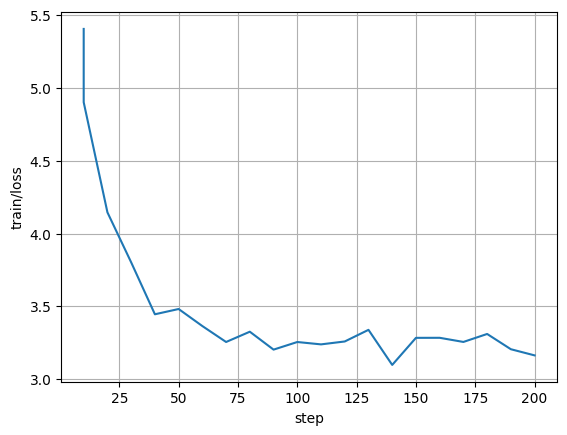

In [55]:
## Plot training loss
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

logdir = "experiments/overfit_exp/tensorboard_logs"  # directory with event files
ea = EventAccumulator(logdir)
ea.Reload()

# list available tags
print(ea.Tags()["scalars"])

# pick one scalar
tag = "train/loss"  # for example
events = ea.Scalars(tag)

steps = [e.step for e in events]
values = [e.value for e in events]

plt.plot(steps, values)
plt.xlabel("step")
plt.ylabel(tag)
plt.grid(True)
plt.show()

---

### 3. Pretrained AudioLLM Evaluation (4 points)

In this section you'll need to: 
* Load pretrained checkpoint with architecture you've implemented

* Write generation method for the model

* Measure the quality of the model on MMLU dataset with *answer probability* - based accuracy


#### Grading Criteria:
* **+2 points:** Completing `generate` function and meaningfull answers on example audios
* **+2 point:** Completed *answer probability* - based accuracy calculation on mmlu_speech subset and reaching `accuracy > 0.4`

---

#### Generation function
First, you'll need to:
* Implement `get_audio_values` and `generate` functions
* Pass example audios into them with or without prompts and demonstrate meaningfull answers

In [ ]:
# Downloading audios we will use in examples

! gdown https://drive.google.com/uc?id=18-9If-0WZH0cPZ9MpQEwCrABA3BrTKBh
! gdown https://drive.google.com/uc?id=1Yv6B3BEMjjmkcK4ogcutyf6gR1QOl3kl

In [ ]:
import IPython
IPython.display.Audio('gagarin_eng.mp3')
# When did Gagarin fly into space?

In [ ]:
import IPython
IPython.display.Audio('gagarin.mp3')
# В каком году Гагарин полетел в космос?

In [ ]:
# Model instantiation
config = ModelConfig(
    whisper_model='openai/whisper-medium',
    llm_model="Qwen/Qwen2.5-1.5B-Instruct",
    adapter_hidden_dim=1536,
    adapter_num_layers=2,
    adapter_dropout=0.1,
    subsample_factor=4,
)
model = AudioLLM(config)

In [ ]:
from huggingface_hub import hf_hub_download

ckpt_path = hf_hub_download(
    repo_id="malex26/dls-course-model",
    filename="model.ckpt",
)

In [ ]:
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt)
model.to(DEVICE)

In [ ]:
def get_audio_values(audio_path: str | Path, features_extractor: WhisperFeatureExtractor) -> torch.Tensor:
    """
    Extracting audio_values tensor from given audio_path
    """
    return None # <TODO>

def generate(
    model: AudioLLM, 
    audio_values: torch.Tensor,
    user_prompt: str = "",
    system_prompt: str = "",
    max_new_tokens: int=128,
    **generation_kwargs,
) -> str:
    """
    Standard generation logic, but with addition of Audio Embeddings
    """
    model = model.eval()
    
    if not AUDIO_TOKEN in user_prompt:
        # model was trained with AUDIO_TOKEN before user text
        user_prompt = AUDIO_TOKEN + user_prompt

    text = None # <TODO>
    input_ids = None# <TODO>

    with torch.no_grad(), torch.autocast(dtype=torch.bfloat16, device_type='cuda'):
        # Obtain audio embeds
        audio_embeds = None #<TODO>

        # Obtain text embeds
        text_embeds = None #<TODO>

        # Combine them
        combined_embeds, _ = None #<TODO>

        # Create attention mask
        attention_mask = torch.ones(
            1, combined_embeds.shape[1],
            device=audio_embeds.device,
            dtype=torch.long
        )

        # Generate
        outputs = None #<TODO>

        # Decode tokens
        generated_text = None #<TODO>


    return generated_text

    

In [ ]:
audio_values = get_audio_values('gagarin_eng.mp3', feature_extractor)

In [ ]:
res = generate(
    model=model,
    audio_values=audio_values,
    user_prompt=f'{AUDIO_TOKEN}Answer the question on audio.'
)

In [ ]:
print(res)

#### Grading Criteria:
* **2 points:** Completed `generate` & `get_audio_values` function and demonstrated meaningfull answers on example audios

---

#### Measure the quality of the model on MMLU dataset with *answer probability* - based accuracy
In this punct you'll evaluate the pretrained AudioLLM model on MMLU-Speech using **probability-based answer extraction**, similar to the method in original [MMLU paper](https://arxiv.org/pdf/2009.03300).

### Method

Instead of generating and parsing text, directly extract the answer by:

1. Create prompt ending with `"Answer:"`
2. Get model's logits for the **next token**
3. Extract probabilities for tokens `" A"`, `" B"`, `" C"`, `" D"` (note: with leading space)
4. Select the option with **highest probability**

**Your goal is**:
* implement this evaluation method
* measure quality on mmlu-speech dataset and reach `accuracy > 0.4` on the `high_school_psychology` subset

#### Grading Criteria:
* **2 points:** Creating probability-based validation function and obtained `accuracy > 0.4` on the `high_school_psychology` subset
* **1 points:** Creating any validation function and obtained `accuracy > 0.3` on the `high_school_psychology` subset

In [ ]:
! pip install datasets==2.21.0 -q

In [ ]:
from datasets import load_dataset

# Dataset downloading, takes about 5 minutes in kaggle notebooks
ds = load_dataset("mistralai/mmlu_speech", split='test')
